In [2]:
import sys
sys.path.append('../..')
import sentinel
import numpy as np
import torch
import matplotlib.pyplot as plt

from sentinel.detectors.custom_detector import BaseCustomDetector

### **Definimos nuestro Custom Detector**

**Base Custom Detector**

In [3]:
class CustomDetector(BaseCustomDetector):
    def __init__(self, threshold_multiplier=2.0):
        self.mean_std = None
        self.threshold_multiplier = threshold_multiplier
        self.threshold = None

    def fit(self, train_data, val_data=None, verbose=False):
        stds = np.std(train_data, axis=1)
        self.mean_std = np.mean(stds)
        std_dev = np.std(stds)
        self.threshold = self.mean_std + self.threshold_multiplier * std_dev

        history = {
            'train': [self.mean_std] * 10,
            'val': [np.mean(np.std(val_data, axis=1))] * 10 if val_data is not None else []
        }
        return history

    def anomaly_score(self, data):
        return np.std(data, axis=1)

    def predict(self, data):
        scores = self.anomaly_score(data)
        return scores > self.threshold

**DerivativeMADDetector Custom** 

Este detector evalúa el cambio abrupto en las señales utilizando la derivada primera de la serie temporal (sensibilidad a cambios rápidos).

In [4]:
class DerivativeMADDetector(BaseCustomDetector):
    def __init__(self, threshold_multiplier=2.0):
        super().__init__()
        self.threshold_multiplier = threshold_multiplier
        self.threshold = None
        self.mean_mad = None

    def fit(self, X, y=None):
        deriv = np.diff(X, axis=1)
        mads = np.mean(np.abs(deriv), axis=1)
        self.mean_mad = np.mean(mads)
        std_mad = np.std(mads)
        self.threshold = self.mean_mad + self.threshold_multiplier * std_mad
        return self  

    def predict(self, X):
        scores = self.anomaly_score(X)
        return (scores > self.threshold).astype(int)

    def anomaly_score(self, X):
        deriv = np.diff(X, axis=1)
        return np.mean(np.abs(deriv), axis=1)

**PatternCorrelationDetector Custom**

Este detector mide la similitud de una serie con una forma esperada (como una onda senoidal), usando la correlación de Pearson.

In [5]:
class PatternCorrelationDetector(BaseCustomDetector):
    def __init__(self, threshold=0.8):
        super().__init__()
        self.pattern = None
        self.threshold = threshold

    def fit(self, X, y=None):
        self.pattern = np.mean(X, axis=0)
        return self

    def predict(self, X):
        scores = self.anomaly_score(X)
        return (scores > (1 - self.threshold)).astype(int)

    def anomaly_score(self, X):
        scores = []
        for x in X:
            corr = np.corrcoef(self.pattern, x)[0, 1]
            scores.append(1 - corr)  # menor correlación => mayor score
        return np.array(scores)

**Simulación para Custom detectors**

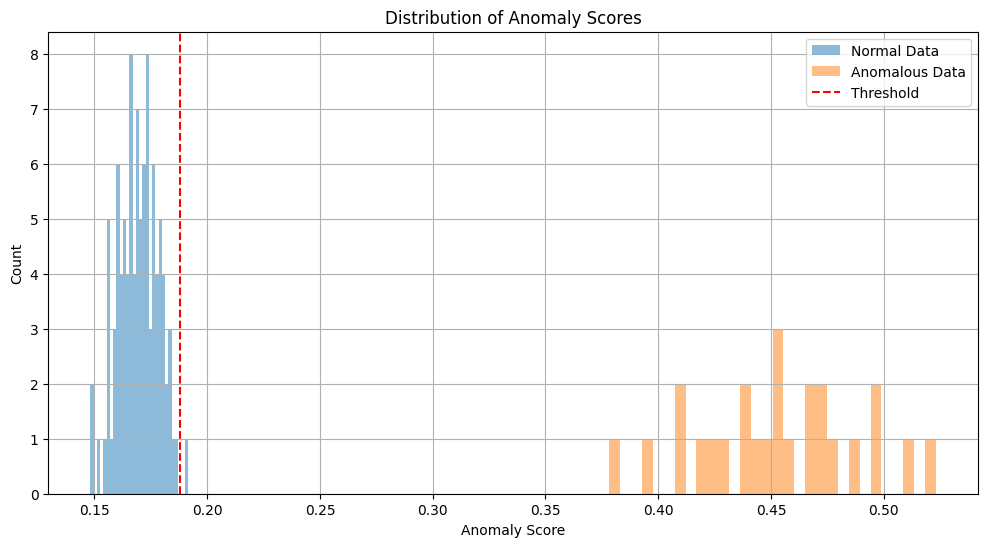

In [6]:
# Simulación de datos
window_size = 60
batch_size = 100
n_features = 1

normal_data = []
for i in range(batch_size):
    t = np.linspace(0, 4*np.pi, window_size)
    normal_series = np.sin(t) + 0.1 * np.random.randn(window_size)
    normal_data.append(normal_series)
normal_data = np.array(normal_data)

anomalous_data = []
for i in range(batch_size // 4):
    t = np.linspace(0, 4*np.pi, window_size)
    anomaly_series = 1.5 * np.sin(1.5*t) + 0.3 * np.random.randn(window_size)
    anomalous_data.append(anomaly_series)
anomalous_data = np.array(anomalous_data)

# from my_custom_module import CustomDetector, DerivativeMADDetector, PatternCorrelationDetector
# detector = CustomDetector(threshold_multiplier=2.0)
detector = DerivativeMADDetector(threshold_multiplier=2.0)
# detector = PatternCorrelationDetector(threshold=0.85)

# Separar datos en entrenamiento y validación
train_size = int(0.8 * len(normal_data))
train_data = normal_data[:train_size]
val_data = normal_data[train_size:]

# Entrenar el detector
detector.fit(train_data, val_data)  

# Calcular puntuaciones de anomalía
normal_scores = detector.anomaly_score(normal_data)
anomalous_scores = detector.anomaly_score(anomalous_data)

# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.hist(normal_scores, bins=30, alpha=0.5, label='Normal Data')
plt.hist(anomalous_scores, bins=30, alpha=0.5, label='Anomalous Data')
plt.axvline(detector.threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True)
plt.show()